# zBEAMS: Application to Strong Lensing 

Importing Omega_k!=0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0


/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
Failed Check: 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


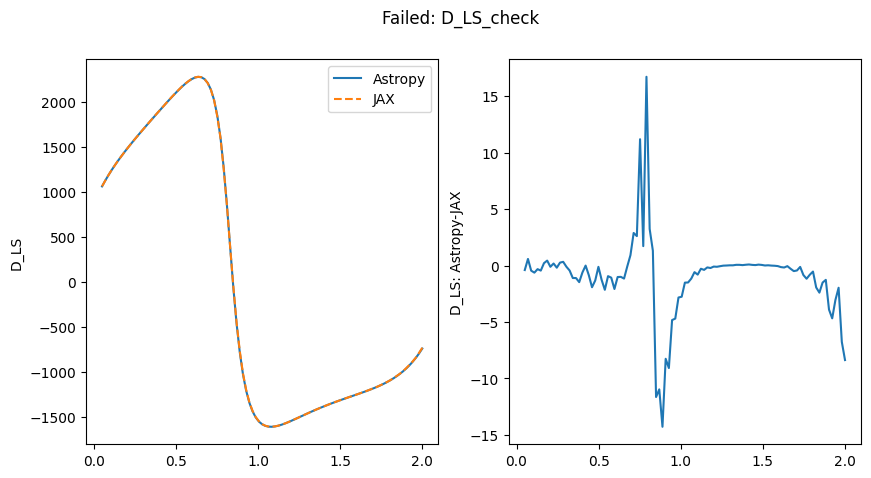

Failed Check (2) 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


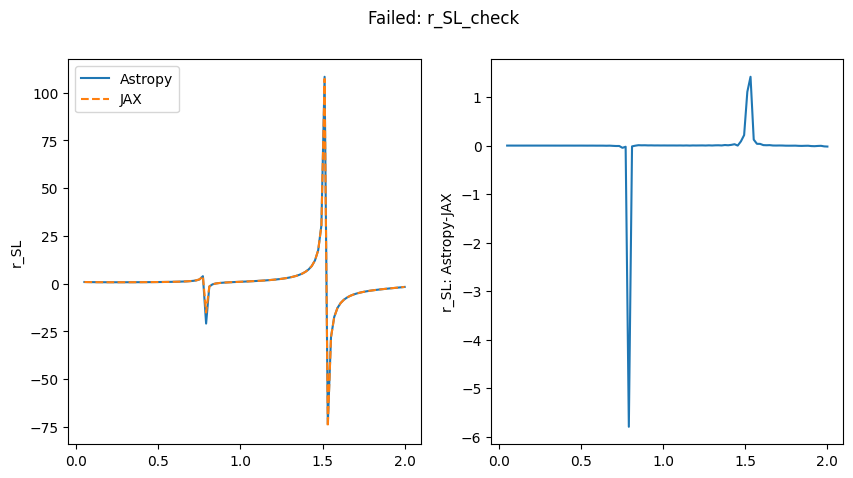

complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Importing Omega_k==0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0
complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Running Omega_k check


 69%|██████▉   | 162/234 [00:00<00:00, 1011126.86it/s]


"\nHave shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further\ndemonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most\nimportantly including contamination + photometry.\n"

In [2]:
from zbeamsfunctions_SL import likelihood_SL,likelihood_spec_contam_SL,likelihood_phot_contam_SL,likelihood_phot_SL,r_SL
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from zbeamsfunctions import mu_w,likelihood,likelihood_spec
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
from Lenstronomy_Cosmology import Background, LensCosmo
from mcmcfunctions import mcmc,mcmc_spec,mcmc_phot
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from scipy.stats import truncnorm, norm
import matplotlib.patches as mpatches
from mcmcfunctions_SL import mcmc_SL
import matplotlib.lines as mlines
from cosmology_JAX import j_r_SL
from jax import random,grad, jit
import matplotlib.pyplot as pl
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import scipy.sparse
import pandas as pd
import arviz as az
import numpy as np
import importlib
import numpyro
import corner
import emcee
import glob
import sys
import jax

try:importlib.reload(sys.modules['mcmcfunctions_SL'])
except Exception as ex: print(f'Cannot reload: {ex}')
from mcmcfunctions_SL import mcmc_SL

Om_fid = 0.2;Ode_fid = 0.8;H0_fid = 70;w_fid = -1.0;wa_fid=0

cosmo_type = 'wCDM'
'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

In [2]:
import sys
#from importlib import reload  # Python 3.4+
#reload(sys.modules['mcmcfunctions_SL_JAX'])
'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

"\nHave shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further\ndemonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most\nimportantly including contamination + photometry.\n"

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as pl
from zbeamsfunctions_SL import likelihood_phot_SL
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC

def phot_likelihood_check():
    '''
    A function to verify if the likelihoods for the emcee and JAX MCMC methods are the same, in the case of a photometric but
    *uncontmainated* sample. 
    Results:
    The results are the same except for w and wa. These return nan's for certain values of w and wa, and differ from the emcee
    likelihood just before this. This may be due to the particular selection of cosmology parameters being unphysical (it 
    seems ok with OM=0.3, but not if OM=0). 
    '''

    likelihood_dict_default = {'H0':70,'OM':0, 'Ok':0, # The default is Om=0 and Ok = 0. This is so when one of them is updated
                               # in likelihood_dict below, it doesn't require Ode to be >1. Otherwise if I let Om or Ok vary between
                               # [0,1] and the other (Ok or Om) is non-zero by default, it would require Ode to be >1.
                                'w':-1,'wa':0,
                                'r_obs':jnp.array([1]),'sigma_r_obs':jnp.array([1]),
                                'zL':1,'zS':2,
                                'zL_obs':jnp.array([1]),'zS_obs':jnp.array([2]),
                                'zL_sigma':0.1,'zS_sigma':0.2,
                                'mu_zL_g_L':1.1,'mu_zS_g_L':2.2,
                                'sigma_zL_g_L':0.1,'sigma_zS_g_L':0.1}
    def jax_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        return j_likelihood_SL(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
            cosmo_type='wCDM',
            photometric=True,
            contaminated=False,
            H0=likelihood_dict['H0'],
            key=PRNGKey(0),
            likelihood_check=True,
            likelihood_dict = likelihood_dict)[0]

    def emcee_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        likelihood_dict['Ode'] = 1-(likelihood_dict['OM']+likelihood_dict['Ok']) #Renaming keys to the correct emcee argument names
        likelihood_dict['si_00_g_L'] = likelihood_dict['sigma_zL_g_L']
        likelihood_dict['si_11_g_L'] = likelihood_dict['sigma_zS_g_L']
        likelihood_dict['sigma_zL_obs'] = likelihood_dict['zL_sigma']
        likelihood_dict['sigma_zS_obs'] = likelihood_dict['zS_sigma']
        likelihood_dict['sigma_r_obs_1'] = likelihood_dict['sigma_r_obs']
        likelihood_dict['zL'] = np.array([likelihood_dict['zL']])
        likelihood_dict['zS'] = np.array([likelihood_dict['zS']])
        for k_i in ['Ok','sigma_zL_g_L','sigma_zS_g_L','zL_sigma','zS_sigma','sigma_r_obs']: #Removing redundant keys
            likelihood_dict.pop(k_i, None)
        return likelihood_phot_SL(**likelihood_dict,cosmo_type='wCDM')

    param_vary_dict = {
                        'zL':np.linspace(0.1,1,10),
                        'zS':np.linspace(1,2,10),
                        'zL_obs':np.linspace(0.1,1,10),
                        'zS_obs':np.linspace(1,2,10),
                        'r_obs':np.linspace(0,2,10),
                        'sigma_r_obs':np.linspace(0.5,5,10),
                        'zL_sigma':np.linspace(0.5,5,10),
                        'zS_sigma':np.linspace(0.5,5,10),
                        'OM':np.linspace(0,1,10),
                        'Ok':np.linspace(0,1,10),
                        'w':np.linspace(-2,0,100),
                        'wa':np.linspace(-3,1,100),
                        'mu_zL_g_L':np.linspace(0.5,5,10),
                        'mu_zS_g_L':np.linspace(0.5,5,10),
                        'sigma_zL_g_L':np.linspace(0.5,5,10),
                        'sigma_zS_g_L':np.linspace(0.5,5,10)
                        }
    for param_i in param_vary_dict.keys():
        L_jax = np.vectorize(jax_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        L_emcee = np.vectorize(emcee_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        try:
            assert (abs((L_jax-L_emcee)/L_jax)<0.01).all()
        except: 
            print(f'ASSERTION ERROR: {param_i}')
            pl.plot(param_vary_dict[param_i],L_jax,label='JAX')
            pl.plot(param_vary_dict[param_i],L_emcee,'--',label='emcee')
            pl.xlabel(param_i)
            pl.legend()
            pl.show()
    
phot_likelihood_check()

In [34]:
norm(loc=np.array([1,20]),scale=np.array([2,3])).rvs()

array([ 1.03464812, 18.65129752])

In [13]:
#zL_obs=db_in['zL_obs'];zS_obs=db_in['zS_obs'];r_obs=db_in['r_obs'];sigma_r_obs=db_in['sigma_r_obs'] #Making these up!!!

def generate_databases(N_obs,true_lens_frac,Percentage_error,cosmo_type,Om_fid,Ode_fid,H0_fid,w_fid,wa_fid,
                       verbose=False):
    if True: 
        print(f'Generating sample of {N_obs} systems, of which {100*true_lens_frac}% are true lenses '+\
              f'with {Percentage_error}% measurement error in a {cosmo_type} cosmology. This has '+\
              f'parameters Om:{Om_fid},Ode:{Ode_fid},H0:{H0_fid} and w:{w_fid}')
    '''
    Need to update this to make 'True' values first, then sample from normal distribution with assumed sigma to get observed
    values. 
    '''
    repeat_0=True
    zL_obs_0 = []
    zS_obs_0 = []
    repeat_0=True
    while repeat_0:
        #Have changed the means of these from (0.5,1) to (0.4,0.8).
        zL_obs_i = truncnorm(-2,np.inf,loc=0.4,scale = 0.2).rvs(size=10*N_obs)
        zS_obs_i = truncnorm(-2,np.inf,loc=0.8,scale=0.4).rvs(size=10*N_obs)
        valid_bool = zL_obs_i<zS_obs_i
        zL_obs_i=zL_obs_i[valid_bool]
        zS_obs_i=zS_obs_i[valid_bool]
        if len(zL_obs_i)>=N_obs:
            zL_obs_true = zL_obs_i[0:N_obs]
            zS_obs_true = zS_obs_i[0:N_obs]
            assert len(zL_obs_true)==N_obs;assert len(zS_obs_true)==N_obs
            repeat_0=False

    '''
    NOTE: I think this may currently be incorrect - r_obs_0 should be measured from theta_E and vel_disp, rather than redshifts?
    '''
    if cosmo_type == 'w0CDM': r_obs_true = r_SL(zL_obs_true,zS_obs_true,wCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid,w0=w_fid))
    if cosmo_type == 'wCDM': r_obs_true = r_SL(zL_obs_true,zS_obs_true,w0waCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid,w0=w_fid,wa=wa_fid))
    if cosmo_type == 'FlatwCDM': r_obs_true = r_SL(zL_obs_true,zS_obs_true,FlatwCDM(H0=H0_fid,Om0=Om_fid,w0=w_fid))
    if cosmo_type == 'LambdaCDM': r_obs_true = r_SL(zL_obs_true,zS_obs_true,LambdaCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid))
    if cosmo_type == 'FlatLambdaCDM': r_obs_true = r_SL(zL_obs_true,zS_obs_true,FlatLambdaCDM(H0=H0_fid,Om0=Om_fid))

    #Breaking the measurements of r_obs if the object is contaminated:
    sigma_r_obs_0 = abs(Percentage_error/100)*r_obs_true
    sigma_zL_obs = abs(Percentage_error/100)*zL_obs_true
    sigma_zS_obs = abs(Percentage_error/100)*zS_obs_true
    p_tau_0 = [np.random.choice([true_lens_frac]) for i in range(len(r_obs_true))]
    contaminated_bool_0 = [np.random.choice([0,1],p=[p_tau_0[i],1-p_tau_0[i]]) for i in range(len(r_obs_true))] #Lens = 0
    #
    r_obs_0 = norm(loc=r_obs_true,scale=sigma_r_obs_0).rvs() #Draw observations randomly from gaussian 
    r_obs_0_contam = [r_obs_0[i] if contaminated_bool_0[i] == 0 else np.random.random() for i in range(len(r_obs_true))]
    #
    zL_obs_0 = -np.ones(len(zL_obs_true))
    zS_obs_0 = -np.ones(len(zS_obs_true))
    while (zL_obs_0<0).any():
        zL_obs_0 = norm(loc = zL_obs_true,scale = sigma_zL_obs).rvs()
    while (zS_obs_0<0).any():
        zS_obs_0 = norm(loc = zS_obs_true,scale = sigma_zS_obs).rvs()
    '''
    Not sure what sigma_r_obs_0 should be if the object is not a lens?
    '''

    db_in = pd.DataFrame({'zL_obs':zL_obs_0,'zS_obs':zS_obs_0,
                        'sigma_zL_obs':sigma_zL_obs,'sigma_zS_obs':sigma_zS_obs,
                        #'r_obs_if_true':r_obs_0, Not using this as its confusing if the system isn't actually a lens.
                        'r_obs_contam': r_obs_0_contam,
                        'sigma_r_obs':sigma_r_obs_0,'P_tau':p_tau_0,'FP_bool':contaminated_bool_0})
#    db_filename = f'./databases/spectroscopic_db_{Percentage_error}perc_{N_obs}_samples_'+\
    db_filename = f'./databases/Gaussian_noise_{Percentage_error}perc_{N_obs}_samples_'+\
                  f'{int(np.round(100*db_in["P_tau"].mean()))}_true_cosmo_{cosmo_type}.csv' 
    print(db_filename)
    db_in.to_csv(db_filename)
    if verbose: print(db_in.describe())

N_lens = 100
for N_obs_i in 2**np.arange(7,17): #np.linspace(100,1000,10):#:
    generate_databases(N_obs=int(N_obs_i),
                       true_lens_frac=1.0,
                       Percentage_error=1,
                       cosmo_type='wCDM',
                       Om_fid=Om_fid,
                       Ode_fid=Ode_fid,
                       H0_fid=H0_fid,
                       w_fid=w_fid,
                       wa_fid=wa_fid,
                       verbose=False)

'''#Note, need the backslash after VARIABLE (in the addqueue...)
print('for VARIABLE in {50..100..2}
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_100_samples_$VARIABLE\_true_cosmo_.csv True False wCDM 1000
done

for VARIABLE in 2 4 8 16 32 64 128 256 512 1024
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_$VARIABLE\_samples_100_true.csv False False wCDM 1000
done
'''

Generating sample of 128 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_128_samples_100_true_cosmo_wCDM.csv
Generating sample of 256 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_256_samples_100_true_cosmo_wCDM.csv
Generating sample of 512 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_512_samples_100_true_cosmo_wCDM.csv
Generating sample of 1024 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv
Generating sample of 2048 systems, of which 100.0% are true le

./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv
Generating sample of 4096 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_4096_samples_100_true_cosmo_wCDM.csv
Generating sample of 8192 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_8192_samples_100_true_cosmo_wCDM.csv
Generating sample of 16384 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_16384_samples_100_true_cosmo_wCDM.csv
Generating sample of 32768 systems, of which 100.0% are true lenses with 1% measurement error in a wCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/Gaussian_noise_1perc_32768_samples_100_tr

"#Note, need the backslash after VARIABLE (in the addqueue...)\nprint('for VARIABLE in {50..100..2}\ndo\naddqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_100_samples_$VARIABLE\\_true_cosmo_.csv True False wCDM 1000\ndone\n\nfor VARIABLE in 2 4 8 16 32 64 128 256 512 1024\ndo\naddqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_$VARIABLE\\_samples_100_true.csv False False wCDM 1000\ndone\n"

In [32]:
db_in.describe()

,Unnamed: 0,zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,r_obs_contam,sigma_r_obs,P_tau,FP_bool
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.0,2048.0
mean,1023.500000,0.391017,0.931870,0.003910,0.009321,0.498604,0.004984,1.0,0.0
std,591.350996,0.180801,0.328174,0.001807,0.003282,0.228520,0.002284,0.0,0.0
min,0.000000,0.003346,0.114397,0.000033,0.001142,0.000623,0.000006,1.0,0.0
25%,511.750000,0.261230,0.698033,0.002613,0.006971,0.339168,0.003398,1.0,0.0
50%,1023.500000,0.389579,0.905855,0.003901,0.009090,0.506920,0.005071,1.0,0.0
75%,1535.250000,0.511136,1.149153,0.005096,0.011512,0.659168,0.006614,1.0,0.0
max,2047.000000,1.069541,2.399797,0.010643,0.023650,0.999338,0.009966,1.0,0.0


In [ ]:
#Spectroscopic no contamination: python3.11-725589.out and python3.11-725590.out
!addqueue -c '1hr' -m 2 -n 1x4 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 10000 
#Spectroscopic 20% Contamination: python3.11-725591.out and python3.11-725592.out
!addqueue -c '1hr' -m 2 -n 1x4 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True False wCDM 1000 2
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True False wCDM 10000 
#Photometric, no contamination: python3.11-725593.out
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#Photometric, with contamination: python3.11-725594.out
!addqueue -c '2hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True True wCDM 2000 2
#100k sample: python3.11-725595.out
!addqueue -c '12hr' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 1


In [24]:
#Photometric, no contamination: JAX: python3.11-727129.out emcee: python3.11-727130.out (=> OOM)
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 10000 

#Photometric, no contamination: JAX with uniform redshift prior: python3.11-727158.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2

#Photometric, no contamination: JAX with Gaussian noise on parent distribution: python3.11-727310.out, python3.11-727311.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_512_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
#And with more systems: python3.11-727312.out, python3.11-727313.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_4096_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9



Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-727312.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-727313.out
Job submission complete.



In [ ]:
'''
Question: Does the GPU thing run faster if I give it more cores (within 1 node)?
Answer: Giving 20GB on 1 node + 1 core was very slow on gpulong_5.
Variable improvement for giving 4x more cores in the same node (1x4 vs 1x1) => Wasn't 4x faster anyway.
-n 1x4 -m 5:  4m20, 7m, 5m
-n 1x1 -m 5:  5m30, 4m, 4m30
-n 1x1 -m 20: 5m20, 3m30, 4m

'''
!addqueue -c '1hr' -m 5 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
!addqueue -c '1hr' -m 5 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
!addqueue -c '1hr' -m 20 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5

In [ ]:
'''
Job List:
725389: 100k samples on GPU
725521: 1024 samples, JAX Not Contaminated but photometric
725522: 1024 samples, emcee Not Contaminated but photometric => Needed far too many walkers (must be >2*ndim) so failed.
'''

In [129]:
'''
To get 100k samples, ran this:
addqueue -c '50min' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 2
Output here: /mnt/zfsusers/hollowayp/zBEAMS/python3.11-725389.out
Ran first chain then ran out of memory when starting the second.
'''

"\nTo get 100k samples, ran this:\naddqueue -c '50min' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 2\n"

### Speed Testing

In [98]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
from scipy.stats import norm
import jax.numpy as jnp
import numpyro
import jax
import time
from jax import local_device_count,default_backend,devices
print('COMPS',local_device_count(),default_backend(),devices()) #= 1 gpu [cuda(id=0)] when run on GPU.

def normpdf(x, mean, sd):
    var = (sd)**2
    return jnp.log(((2*jnp.pi*var)**-0.5)*(jnp.exp(-(x-(mean))**2/(2*var))))

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(normpdf)(x,mu,sigma)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = infer.MCMC(
        infer.NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=False)
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

st=time.time()
N_iter=2
for i in range(N_iter):
    a=run_MCMC()
t_iter=(time.time()-st)/N_iter
print(f"{t_iter} per iteration") #3.5s for GPU, 2s for CPU.

COMPS 1 cpu [CpuDevice(id=0)]


/tmp/ipykernel_23961/3814160675.py:24: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(
/tmp/ipykernel_23961/3814160675.py:24: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(


2.6658490896224976 per iteration


In [79]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import numpyro
import jax
from scipy.stats import norm
import time

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(dist.Normal)(mu,sigma).log_prob(x)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = infer.MCMC(
        infer.NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=True,
        chain_method='parallel')
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

st=time.time()
N_iter=10
for i in range(N_iter):
    a=run_MCMC()
t_iter=(time.time()-st)/N_iter
print(f"{t_iter} per iteration")

/tmp/ipykernel_23961/3728878216.py:20: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(


sample: 100%|██████████| 1100/1100 [00:00<00:00, 2464.17it/s, 3 steps of size 9.54e-01. acc. prob=0.90]
/tmp/ipykernel_23961/3728878216.py:20: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(
sample: 100%|██████████| 1100/1100 [00:00<00:00, 2280.58it/s, 3 steps of size 7.98e-01. acc. prob=0.92]
/tmp/ipykernel_23961/3728878216.py:20: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sample

2.887103486061096 per iteration


### Assorted Investigations 

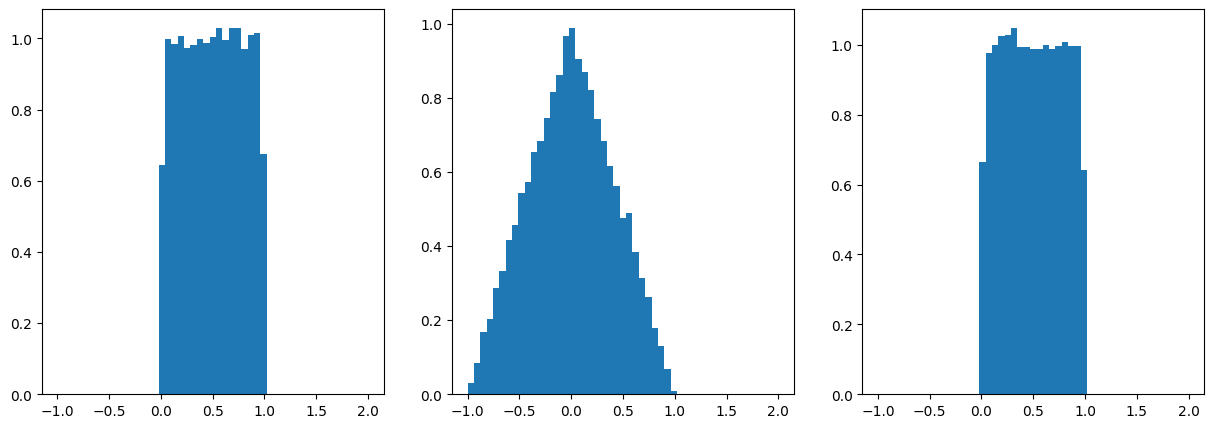

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
a = np.random.random(size=int(1e+5))
b=2*np.random.random(size=int(1e+5))-1
c=1-(a+b)
hist_dict = {'density':True,'bins':np.linspace(-1,2,50)}
ax[0].hist(a[(c<1)&(c>0)],**hist_dict)
ax[1].hist(b[(c<1)&(c>0)],**hist_dict)
ax[2].hist(c[(c<1)&(c>0)],**hist_dict)
pl.show()

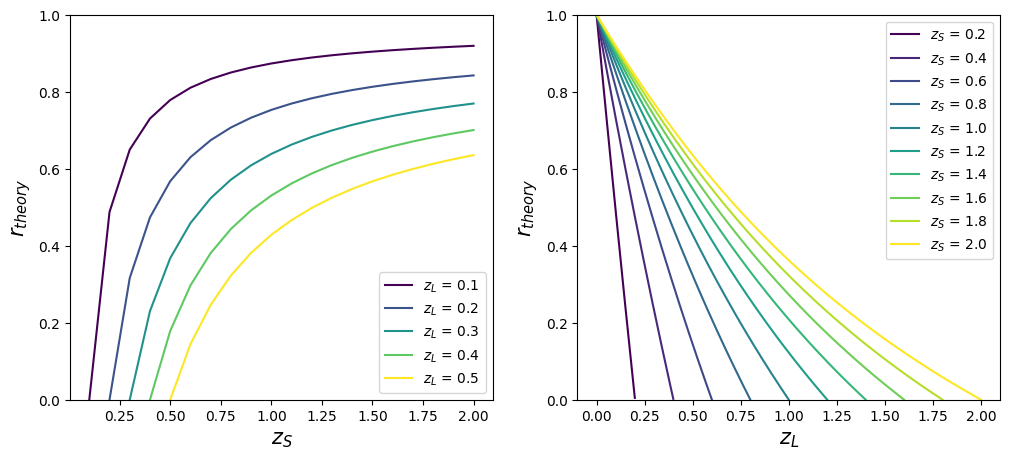

In [ ]:
#Pick some zL values:
zL_list_0 = np.round(np.arange(0.1,0.6,0.1),2)
#Choose range of zS to go with each one:
zS_list_0 = [np.arange(zL_i,2.1,0.1) for zL_i in zL_list_0]
#Calculate corresponding theoretical r value:
r_theory_list_0 = [r_SL(zL_list_0[i],zS_list_0[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_0))]
color_list_0 = pl.cm.viridis(np.linspace(0,1,len(zL_list_0)))

#Pick some zL values:
zS_list_1 = np.round(np.arange(0.2,2.2,0.2),2)
#Choose range of zL values to go with each one:
zL_list_1 = [np.arange(0,zS_i,0.001) for zS_i in zS_list_1]
#Calculate theoretical corresponding r value:
r_theory_list_1 = [r_SL(zL_list_1[i],zS_list_1[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_1))]
color_list_1 = pl.cm.viridis(np.linspace(0,1,len(zS_list_1)))

#Plot variation in r:
fig,ax = pl.subplots(1,2,figsize=(12,5))
for c_i in range(len(zL_list_0)):
    ax[0].plot(zS_list_0[c_i],r_theory_list_0[c_i],c=color_list_0[c_i])
for c_i in range(len(zS_list_1)):
    ax[1].plot(zL_list_1[c_i],r_theory_list_1[c_i],c=color_list_1[c_i])

ax[0].legend([f'$z_L$ = {zL_i}' for zL_i in  zL_list_0])
ax[1].legend([f'$z_S$ = {zS_i}' for zS_i in  zS_list_1])

ax[0].set_xlabel('$z_S$',fontsize=15)
ax[1].set_xlabel('$z_L$',fontsize=15)
for i in range(2):
    ax[i].set_ylabel('$r_{theory}$',fontsize=15)
    ax[i].set_ylim(0,1)

pl.show()

'''Takeaways: 
- Large variation in r if zL is unknown. If zL is uncertain, could explain many values of r within the uncertainty,
without resorting to constraining the cosmology.
- Large variation in r if zS is small and unknown, but smaller variation if zS is larger. If zS is uncertain but large, will get
smaller uncertainty in the theoretical value of r_theory, allowing more constraining power on the cosmology.
  '''

In [42]:
import numpyro


<function numpyro.util.set_host_device_count(n)>

In [ ]:
#!python3 -m pip install arviz
import arviz as az
#az.style.use("arviz-plasmish")
az.style.use('arviz-doc')
#az.style.available

In [79]:
import subprocess
N_lens = 100
for N_obs_i in np.linspace(100,1000,10):
    subprocess.run("addqueue -c '1hr' -m 4 -n 1x2 -s -q planet "+\
            f"/mnt/users/hollowayp/python11_env/bin/python3.11 "+\
            f" ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_"+\
            f"{int(N_obs_i)}_samples_{int(np.round(100*N_lens/N_obs_i))}_true_cosmo_wCDM.csv True False wCDM 2000 10 5000 0.99",
            shell=True)

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-727236.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-727237.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-727238.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-727239.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-727240.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_

### MCMC Results

In [16]:
Prefix = 'SL_orig_Gaussian_noise_'#'SL_orig_spectroscopic_db_'
Errors_perc = 1
N_samples = 2048
Perc_true = 100
contamination_str = 'False'
photometric_str = 'True'
cosmo_type_str = 'wCDM'
cosmo_db_str='wCDM'

import glob;import pandas as pd
def locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,JAX=False,
                         cosmo_db_str='',return_db=False):
    if cosmo_db_str=='':
        cosmo_db_str=cosmo_type_str
    file_search = f'./chains/{Prefix}{Errors_perc}perc_'+\
                                                 f'{N_samples}_samples_{Perc_true}_true_cosmo_{cosmo_db_str}.csv'+\
                                                 f'_ph_{photometric_str}_con_{contamination_str}'+\
                                                 f'_{cosmo_type_str}_'+\
                                                 'mcmc'*(JAX==False)+'JAX'*(JAX==True)+'_chains*'
    print(file_search)
    mcmc_file_list = glob.glob(file_search)
    print('File Found: ',mcmc_file_list)
    if not JAX: latest_chain_indx = np.argmax([float(elem.split('mcmc_chains_')[1].replace('.npy','')) \
                           for elem in mcmc_file_list])
    else: latest_chain_indx = np.argmax([float(elem.split('JAX_chains_')[1].replace('.csv','')) \
                           for elem in mcmc_file_list])
    latest_chain_filename = mcmc_file_list[latest_chain_indx]
    if not JAX: chains = np.load(latest_chain_filename) #[Walker,Step_Number,Parameter]
    if JAX: chains = pd.read_csv(latest_chain_filename)
    print(f'Loading mcmc chains from {latest_chain_filename}')
    if return_db:
        db_filename = latest_chain_filename.split('.csv')[0]+'.csv'
        db_filename = db_filename.replace('/chains','/databases').replace('SL_orig_','')
        db_i = pd.read_csv(db_filename)
        return chains,db_i
    else:
        return chains

# chain_dict = {}
# N_lens = 100
# for N_obs_i in np.linspace(100,1000,10):
#     chain_dict[int(np.round(100*N_lens/N_obs_i))] = locate_latest_chains(
#         Errors_perc,
#         int(N_obs_i),
#         int(np.round(100*N_lens/N_obs_i)),
#         contamination_str,
#         photometric_str,cosmo_type_str,
#         JAX=True,
#         cosmo_db_str=cosmo_db_str)

# chains = locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,cosmo_db_str=cosmo_db_str)
JAX_chains,db_in = locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,
                                        cosmo_type_str,JAX=True,cosmo_db_str=cosmo_db_str,return_db=True)
                                        

./chains/SL_orig_Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains*
File Found:  ['./chains/SL_orig_Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1705446130.9191325.csv']
Loading mcmc chains from ./chains/SL_orig_Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1705446130.9191325.csv


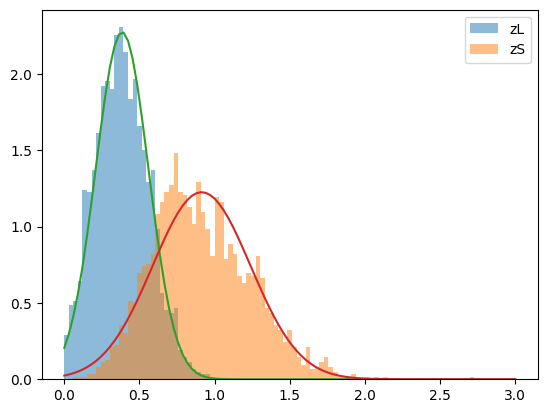

In [32]:
from scipy.stats import norm
hist_dict = {'bins':np.linspace(0,3,100),'alpha':0.5,'density':True}
pl.hist(db_in['zL_obs'],label='zL',**hist_dict)
pl.hist(db_in['zS_obs'],label='zS',**hist_dict)
X_plot = np.linspace(0,3,100)
pl.plot(X_plot,norm.pdf(x=X_plot,loc=db_in['zL_obs'].mean(),scale=db_in['zL_obs'].std()))
pl.plot(X_plot,norm.pdf(x=X_plot,loc=db_in['zS_obs'].mean(),scale=db_in['zS_obs'].std()))
pl.legend()
pl.show()

In [ ]:
FROM GROUP MEETING:
SIMON:
Check the likelihood is the same, before doing any MCMC, 
if it is the same, they should give the same result!
Perhaps can do specifically hamiltonian monte carlo if 
using jax - as then explicitly using the gradient - otherwise
am I just using numpyro + jax.jit? 

In [17]:
JAX_chains['OM_0']

0      0.589715
1      0.589710
2      0.589710
3      0.589710
4      0.589710
         ...   
995    0.589692
996    0.589692
997    0.589692
998    0.589692
999    0.589692
Name: OM_0, Length: 1000, dtype: float64

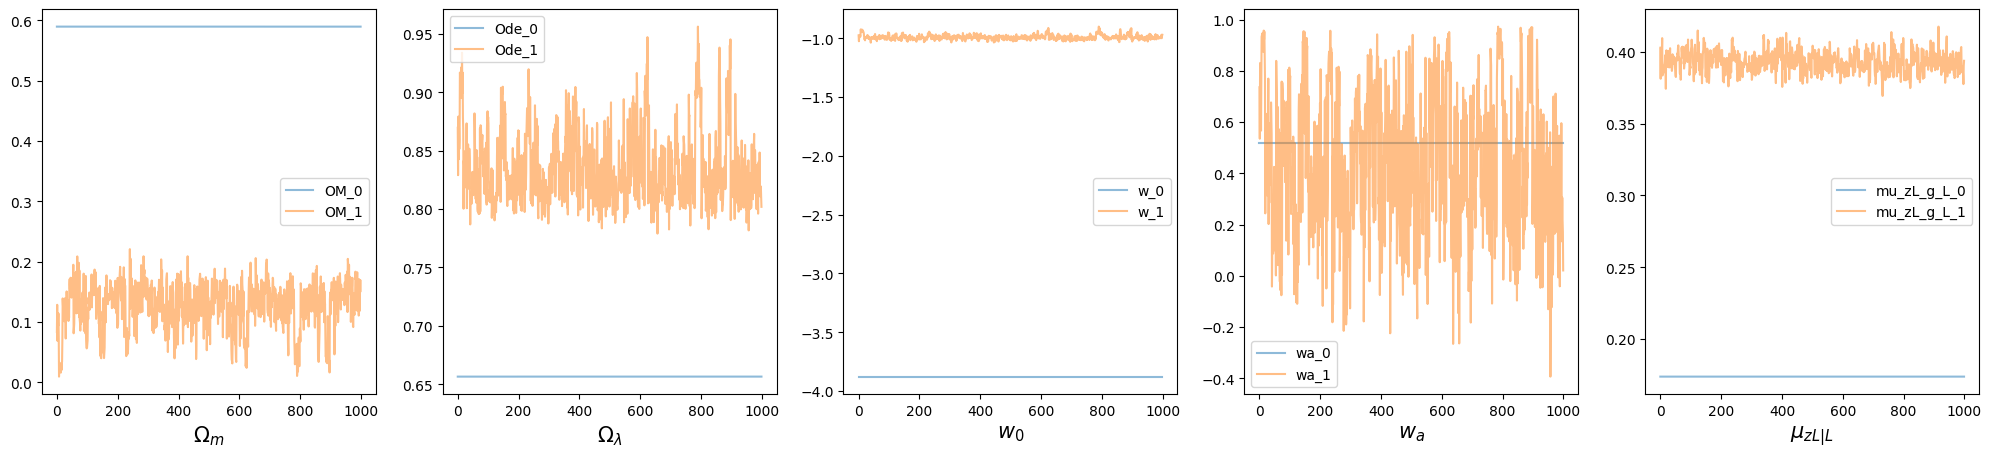

In [18]:
#for k_i in chain_dict.keys():
#    JAX_chains = chain_dict[k_i]
fig,ax = pl.subplots(1,5,figsize=(25,5))
column_list = JAX_chains.columns
#rfind finds the index of the last occurrence of the character in a string: 
column_set = list(set([elem[:elem.rfind('_')] for elem in column_list]))
column_dict = {"OM":0,"Ode":1,'w':2,'wa':3,'Ok':4,'mu_zL_g_L':4}
for c_i in JAX_chains.keys():
    c_i_set = c_i[:c_i.rfind('_')]
    try:
        ax[column_dict[c_i_set]].plot(JAX_chains[c_i],alpha=0.5,label=c_i)
        ax[column_dict[c_i_set]].set_xlabel(label_dict[c_i_set],fontsize=15)
        ax[column_dict[c_i_set]].legend()
    except KeyError:
        pass 
    #ax[column_dict[c_i_set]].set_title(c_i)
#pl.suptitle(f'Key: {k_i}')
pl.show()

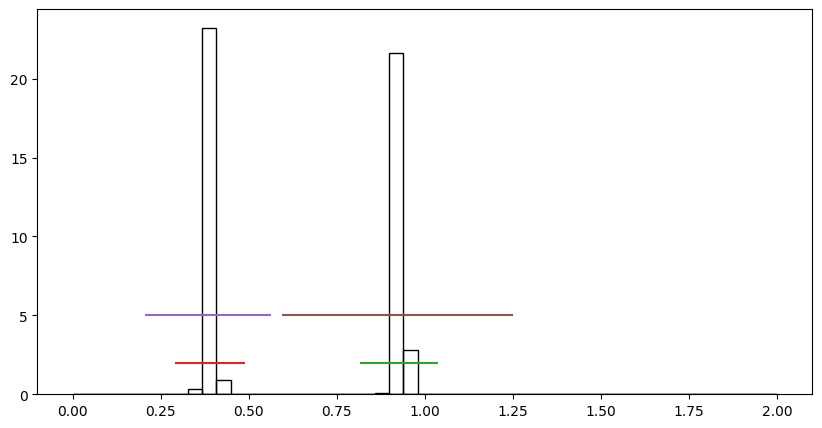

In [70]:
fig,ax = pl.subplots(1,figsize=(10,5))
hist_dict = {'bins':np.linspace(0,2,50),'fill':False,'edgecolor':'k','density':True}
#post = squash_walkers(JAX_chains)
ax.hist(post['mu_zL_g_L'],**hist_dict)
ax.hist(post['mu_zS_g_L'],**hist_dict)
#Inferred zL and zS population
ax.errorbar(post['mu_zS_g_L'].mean(),2,xerr=post['sigma_zS_g_L'].mean())
ax.errorbar(post['mu_zL_g_L'].mean(),2,xerr=post['sigma_zL_g_L'].mean())
#True zL and zS population 
ax.errorbar(db_in['zL_obs'].mean(),5,xerr=db_in['zL_obs'].std())
ax.errorbar(db_in['zS_obs'].mean(),5,xerr=db_in['zS_obs'].std())
pl.show()

In [ ]:
fig,ax = pl.subplots(1,5,figsize=(20,5))
for p_i in range(5):
    for i in range(len(chains)):
        ax[p_i].plot(chains[i,:,p_i],c='k',alpha=0.05)
    if p_i<5: ax[p_i].set_xlabel(['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$'][p_i],fontsize=15)
pl.show()

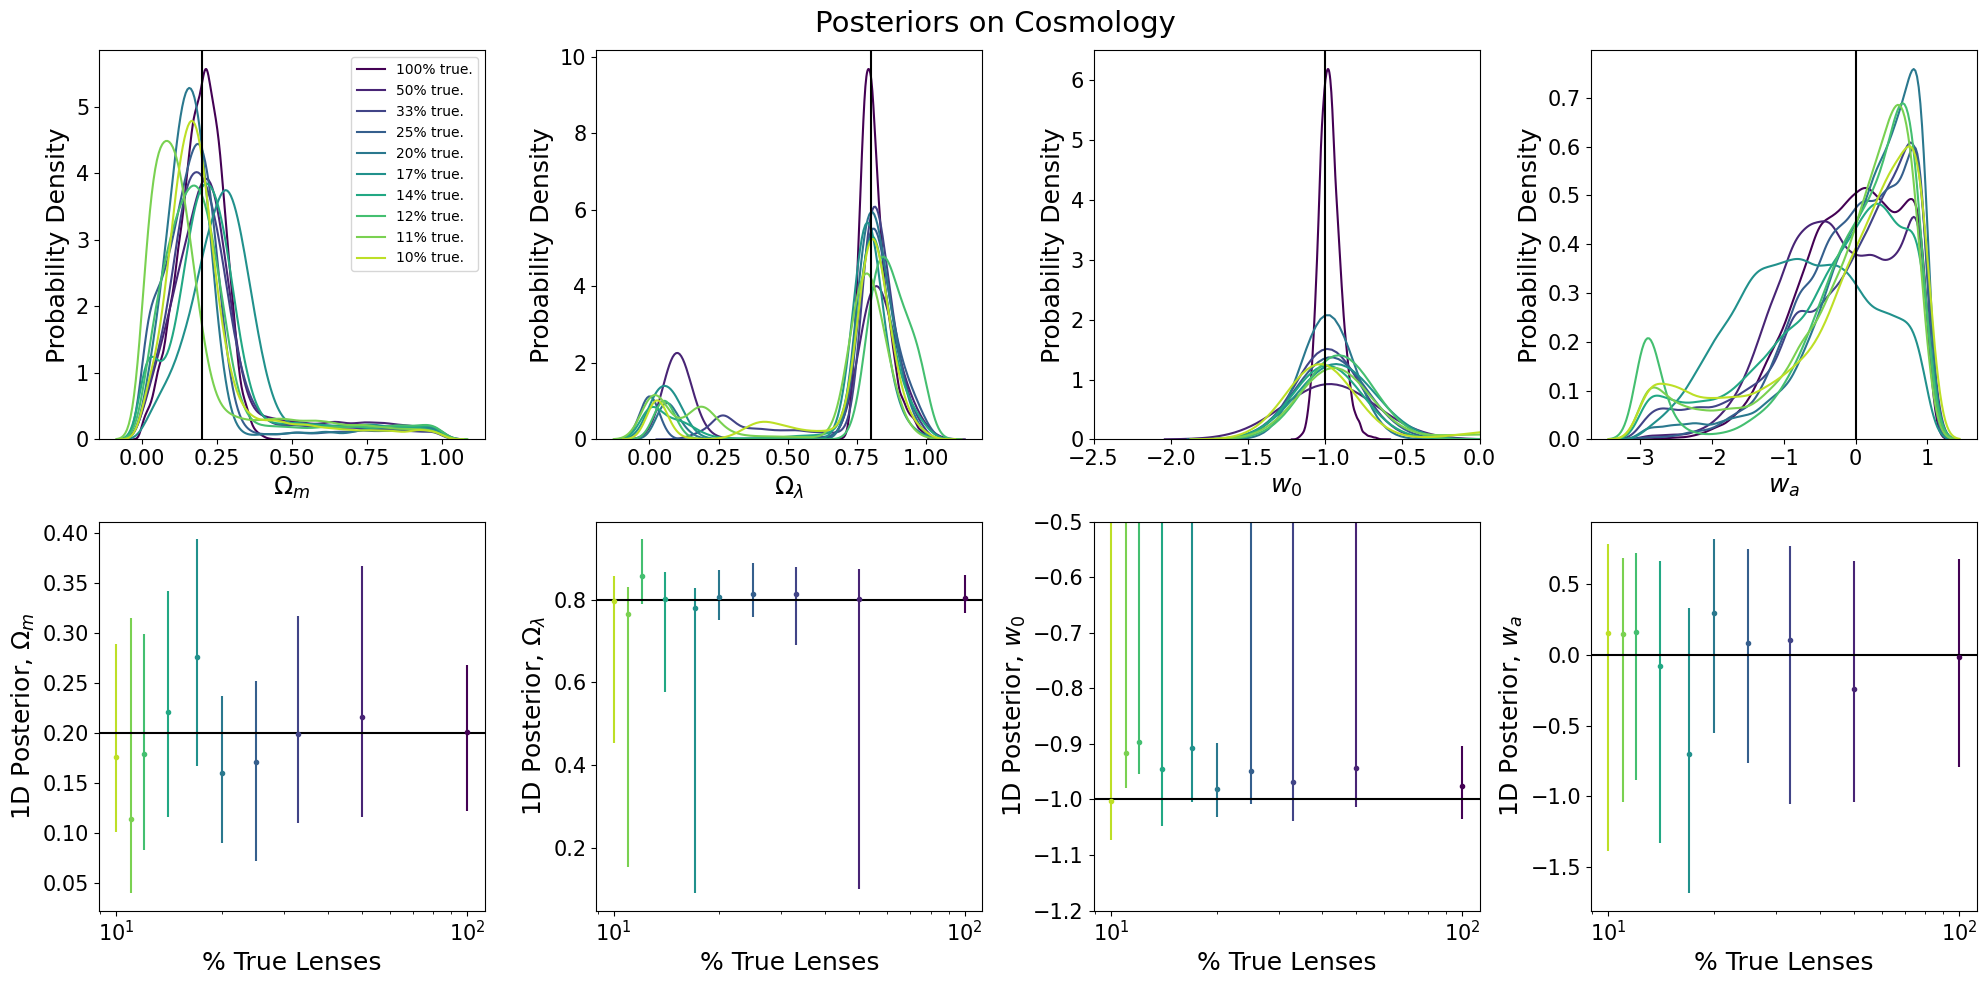

In [16]:
#!python3 -m pip install seaborn
from seaborn import kdeplot
bin_dict = {'OM':np.linspace(0.0,0.6,20),
            'Ode':np.linspace(0.6,1.1,20),'Ok':np.linspace(-1,1,20),
            'w':np.linspace(-1.2,-0.6,20),'wa':np.linspace(-3,1,20)}

def plot_1D_hist(JAX_sampler,fig=None,ax=None,N_keys=None,iter=np.nan,label='_nolegend_',two_rows=False):
    cl = pl.cm.viridis(np.linspace(0,1,N_keys+1))[iter]
    k_list = ['OM','Ode','w','wa','Ok']
    plot_N = len(k_list)
    for k_i in k_list: 
        if k_i not in squash_walkers(JAX_sampler).columns: plot_N-=1;k_list.remove(k_i)
    if fig is None: fig,ax = pl.subplots(1+two_rows,plot_N,figsize=(5*plot_N,5*(1+two_rows)))
    hist_dict = {'fill':False,'density':True}
    for p_i,k_i in enumerate(k_list):
        #ax[p_i].hist(squash_walkers(JAX_sampler)[k_i],**hist_dict,
        #             bins=bin_dict[k_i],edgecolor=cl)
        if two_rows: ax_i = ax[0,p_i]
        else: ax_i = ax[p_i]
        kdeplot(data=squash_walkers(JAX_sampler)[k_i], ax=ax_i,color=cl,label=label)
        if iter==N_keys-1: 
            ax_i.set_xlabel(label_dict[k_i],fontsize=18)
            ax_i.set_ylabel('Probability Density',fontsize=18)
            ax_i.tick_params(labelsize=15)
            ylim = ax_i.get_ylim()
            ax_i.set_ylim(ylim)
            ax_i.plot([{'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid}[k_i]]*2,ylim,c='k')
            if p_i ==2: ax_i.set_xlim(-2.5,0)

    return fig,ax

def plot_uncertainty(JAX_sampler,fig,ax,N_keys=None,iter=np.nan,perc_true=np.nan,two_rows=False):
    cl = pl.cm.viridis(np.linspace(0,1,N_keys+1))[iter]
    k_list = ['OM','Ode','w','wa','Ok']
    plot_N = len(k_list)
    for k_i in k_list: 
        if k_i not in squash_walkers(JAX_sampler).columns: plot_N-=1;k_list.remove(k_i)
    if fig is None: fig,ax = pl.subplots(1,plot_N,figsize=(5*plot_N,5))
    for p_i,k_i in enumerate(k_list):
        if two_rows: ax_i = ax[1,p_i]
        else: ax_i = ax[p_i]
        perc_50 = np.median(squash_walkers(JAX_sampler)[k_i])
        perc_84 = np.percentile(squash_walkers(JAX_sampler)[k_i],84)
        perc_16 = np.percentile(squash_walkers(JAX_sampler)[k_i],16)
        ax_i.errorbar(perc_true,perc_50,color=cl,yerr=np.array([[perc_50-perc_16,perc_84-perc_50]]).T,fmt='.')
        if iter==N_keys-1: 
            ax_i.set_xscale('log')
            ax_i.set_xlabel('% True Lenses',fontsize=18)
            ax_i.set_ylabel(f'1D Posterior, {label_dict[k_i]}',fontsize=18)
            ax_i.tick_params(labelsize=15)
            xlim = ax_i.get_xlim();ax_i.set_xlim(xlim)
            ax_i.plot(xlim,[{'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid}[k_i]]*2,c='k')
        if p_i ==2: ax_i.set_ylim(-1.2,-0.5)
    return fig,ax

fig,ax = None,None
N_keys = len(chain_dict.keys())
for ii,k_ii in enumerate(chain_dict.keys()):
    #if ii!=N_keys-1: continue #=> Plots only the last key.
    fig,ax = plot_1D_hist(chain_dict[k_ii],fig,ax,N_keys=N_keys,iter=ii,label=f'{k_ii}% true.',two_rows=True)
    fig,ax = plot_uncertainty(chain_dict[k_ii],fig,ax,N_keys=N_keys,iter=ii,perc_true=k_ii,two_rows=True)

ax[0,0].legend()
pl.suptitle('Posteriors on Cosmology',fontsize=21)
pl.tight_layout()
pl.show()



In [ ]:
Perc_list = np.arange(50,102,2).astype('int')
N_samples_list = 2**np.arange(1,11)
#fig,ax = pl.subplots(1,len(Perc_list),figsize=(5*len(Perc_list),5))
fig,ax = pl.subplots(1,4,figsize=(20,5))
mu_dict = {}
si_dict = {}
#for p_i in range(len(Perc_list)):
for p_i in range(len(N_samples_list)):
    chains_i = locate_latest_chains(Errors_perc=1,
                                    N_samples=N_samples_list[p_i],
                                    Perc_true=100,
                                    contamination_str='False',
                                    photometric_str='False',
                                    cosmo_type_str='wCDM')
    N_steps_i = len(chains_i[0,:,0])
    burnin_i = int(0.5*N_steps_i)
    print(f'Found {N_steps_i} steps, using burnin of {burnin_i}')
    try: 
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']): 
            mu_dict[cosmo_prop].append(np.mean(chains_i[:,burnin_i:,c_i]))
            si_dict[cosmo_prop].append(np.std(chains_i[:,burnin_i:,c_i]))
    except:
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
            mu_dict[cosmo_prop] = [np.mean(chains_i[:,burnin_i:,c_i])]
            si_dict[cosmo_prop] = [np.std(chains_i[:,burnin_i:,c_i])]

for ii,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
#    ax[ii].errorbar(Perc_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
    ax[ii].errorbar(N_samples_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
#    ax[ii].set_xlabel('% true lenses',fontsize=15)
    ax[ii].set_xlabel('Sample Size',fontsize=15)
    ax[ii].set_xscale('log')
    ax[ii].set_ylabel('$\mu\pm\sigma$',fontsize=15)
    ax[ii].set_title({'Om':'$\Omega_m$','Ode':'$\Omega_\Lambda$','H0':'$H_0$','w':'$w$','wa':'$w_a$'}[cosmo_prop],fontsize=18)
    ax[ii].tick_params(labelsize=10)
#    ax[ii].plot([min(Perc_list),max(Perc_list)],[[Om_fid,Ode_fid,H0_fid,w_fid][ii]]*2,c='k')
    ax[ii].plot([min(N_samples_list),max(N_samples_list)],[[Om_fid,Ode_fid,H0_fid,w_fid,wa_fid][ii]]*2,c='k')

#pl.suptitle('Precision with contaminated sample',fontsize=18)
pl.suptitle('Precision with varying sample size',fontsize=18)
pl.tight_layout()
pl.show()

In [5]:
def squash_walkers(db,exclude=[]):
    column_list = db.columns
    #rfind finds the index of the last occurrence of the character in a string: 
    column_set = list(set([elem[:elem.rfind('_')] for elem in column_list]))
    column_dict = {}
    for c_i in column_list:
        c_i_set = c_i[:c_i.rfind('_')]
        if int(c_i.split('_')[-1]) in exclude:
            print(f'Excluding {c_i}')
            continue
        try:
            column_dict[c_i_set].extend(np.array(db[c_i]))
        except:
            column_dict[c_i_set] = list(db[c_i])
    db_flat = pd.DataFrame(column_dict)
    return db_flat

Excluding OM_0
Excluding Ode_0
Excluding mu_zL_g_L_0
Excluding mu_zS_g_L_0
Excluding sigma_zL_g_L_0
Excluding sigma_zS_g_L_0
Excluding w_0
Excluding wa_0
Excluding zL_0_0
Excluding zL_1_0
Excluding zL_2_0
Excluding zL_3_0
Excluding zL_4_0
Excluding zL_5_0
Excluding zL_6_0
Excluding zL_7_0
Excluding zL_8_0
Excluding zL_9_0
Excluding zL_10_0
Excluding zS_0_0
Excluding zS_1_0
Excluding zS_2_0
Excluding zS_3_0
Excluding zS_4_0
Excluding zS_5_0
Excluding zS_6_0
Excluding zS_7_0
Excluding zS_8_0
Excluding zS_9_0
Excluding zS_10_0
Making into a list
Keys: ['OM', 'w', 'wa']
NOTE: Need to change this so the bins cover the whole prior:
TRUTH [0.2, -1.0, 0]


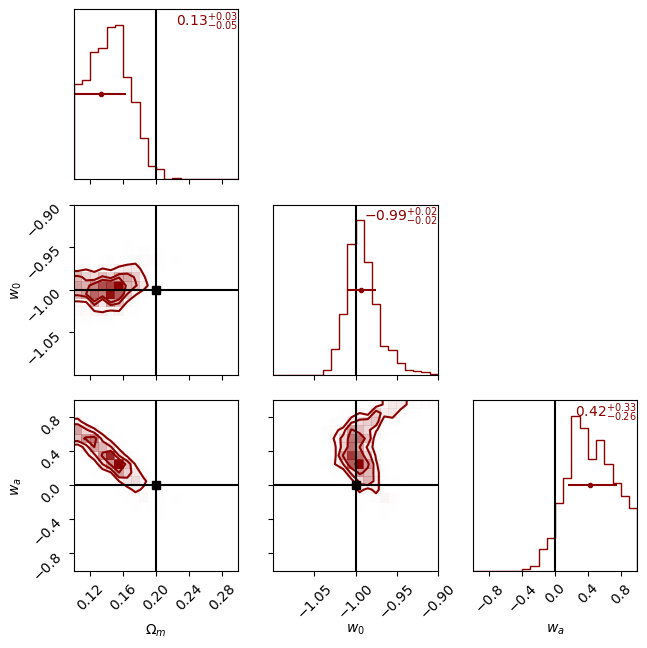

"\nHave shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further\ndemonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most\nimportantly including contamination + photometry.\n"

In [21]:
range_dict = {'OM':(0.1,0.3),'Ode':(0.7,0.9),'Ok':(-1,1),
            'w':(-1.1,-0.9),'wa':(-1,1),
            'mu_zL_g_L':(0,1.5),'mu_zS_g_L':(0,3),
            'mu_zL_g_NL':(0,5),'mu_zS_g_NL':(0,5),
            'sigma_zL_g_L':(0,2),'sigma_zS_g_L':(0,2),
            'sigma_zL_g_NL':(0.1,5),'sigma_zS_g_NL':(0.1,5),
            'zL':(0,1.5),'zS':(0,3),'t':(0,2),'t_mu':(0,2)}
label_dict = {'OM':'$\Omega_m$','Ode':'$\Omega_\lambda$','Ok':'$\Omega_k$',
            'w':'$w_0$','wa':'$w_a$','H0':'H0',
            'mu_zL_g_L':'$\mu_{zL|L}$','mu_zL_g_NL':'$\mu_{zL|NL}$',
            'mu_zS_g_L':'$\mu_{zS|L}$','mu_zS_g_NL':'$\mu_{zS|NL}$',
            'sigma_zL_g_L':'$\sigma_{zL|L}$','sigma_zL_g_NL':'$\sigma_{zL|NL}$',
            'sigma_zS_g_L':'$\sigma_{zS|L}$','sigma_zS_g_NL':'$\sigma_{zS|NL}$',
            't':'Test Sampler','t_mu':'Test Sampler ($\mu$)'}

def del_chains_in_mcmc(mcmc_dict,exclude):
    print(f'Excluding {exclude} from emcee plots')
    for k_ii in mcmc_dict.keys():
        L = mcmc_dict[k_ii].shape[0]
        mcmc_dict[k_ii]=np.delete(mcmc_dict[k_ii],exclude,axis=0)
        assert mcmc_dict[k_ii].shape[0] == L-len(exclude)
    return mcmc_dict

def percentile_str(v,dp=2):
    perc_50 = np.round(np.percentile(v,50),dp).astype('str')
    perc_84_50 =  np.round(np.percentile(v,84)-np.percentile(v,50),dp).astype('str')
    perc_50_16 =  np.round(np.percentile(v,50)-np.percentile(v,16),dp).astype('str')
    return f'${perc_50}'+"_{-"+perc_50_16+"}^{+"+perc_84_50+'}$'

def plot_mu_sig(ax,v,c,y_frac=0.5):
    v=v.flatten()
    perc_50 = np.percentile(v,50)
    perc_84_50 =  float(np.percentile(v,84)-np.percentile(v,50))
    perc_50_16 =  float(np.percentile(v,50)-np.percentile(v,16))
    ylim = ax.get_ylim()
    ax.errorbar(perc_50,y_frac*ylim[1],xerr=np.array([[perc_50_16,perc_84_50]]).T,fmt='.',c=c)
    ax.set_ylim(ylim)

def plot_emcee_corner(MCMC_chain_dict = {},key_list = [],
                    truth_dict={},range_dict={},label_dict = {},bin_dict = {},
                    burnin=np.nan,exclude=[]):
    MCMC_chain_dict = del_chains_in_mcmc(MCMC_chain_dict,exclude)
    corner_array = np.array([MCMC_chain_dict[k_i][:,burnin:] for k_i in key_list]).T
    label_list = [label_dict[k_i] for k_i in key_list]
    truth_list = [truth_dict[k_i] for k_i in key_list]
    range_list = [range_dict[k_i] for k_i in key_list]
    #bin_list = [bin_dict[k_i] for k_i in key_list]
    fig,ax = pl.subplots(len(key_list),len(key_list),figsize=(2.2*len(key_list),2.2*len(key_list)))
    corner.corner(corner_array,
                    truths = truth_list,
                    truth_color='k',
                    contour_kwargs = {'colors':'k'},
                    labels = label_list,
                    label_kwargs={'fontsize':18},
                    range = range_list,
                    fig=fig,
                    hist_kwargs={'density':True},
                    plot_datapoints=False)#,show_titles=True)
    for p_i in range(corner_array.shape[2]):
        ax[p_i,p_i].text(0,1,percentile_str(corner_array[:,:,p_i]),
                        horizontalalignment='left',
                        verticalalignment='top',
                        color='k',
                        transform=ax[p_i,p_i].transAxes,
                        fontsize=10)
        plot_mu_sig(ax[p_i,p_i],corner_array[:,:,p_i],c='k',y_frac=0.4)
    hist_ylim=[]
    for i in range(len(ax)):
        for j in range(len(ax)):
            if i!=j:
                ax[i,j].set_xlim(ax[j,j].get_xlim())
                ax[i,j].set_ylim(ax[i,i].get_xlim())
            else:
                hist_ylim.append(ax[i,j].get_ylim())
    pl.tight_layout()
    return fig,ax,hist_ylim

def plot_JAX_corner(sampler_list,
                    truth_dict={},range_dict={},label_dict = {},bin_dict = {},
                    key_list=[],legend_list=[],plot_Ok=False,fig=None,ax=[],burnin=np.nan,hist_ylim=[],exclude_walker_list=[]):
    if not isinstance(sampler_list, list):
        print('Making into a list')
        sampler_list=[sampler_list]
    if len(key_list)==0: #Plotting all except zL, zS 
        key_list=list(sampler_list[0].columns)
        try:key_list.remove('zL');key_list.remove('zS')
        except: pass
    print('Keys:',key_list)
    print('NOTE: Need to change this so the bins cover the whole prior:')
    #N_chains = sampler_list[0].num_chains
    for s_i,sampler in enumerate(sampler_list):
        corner_samples = sampler[key_list]
        if plot_Ok:
            Ok = np.array([1-(sampler['OM']+sampler['Ode'])])
            sampler['Ok'] = Ok
            key_list.append('Ok')
        #if len(exclude_walker_list)>0: print(f'Excluding {len(exclude_walker_list)} walkers from the plot')
        #corner_samples=np.delete(corner_samples,exclude_walker_list,axis=1)
        if s_i == len(sampler_list)-1: truths=[truth_dict[k] for k in key_list]
        else: truths=None
        if fig is None: 
            fig,ax = pl.subplots(len(key_list),len(key_list),figsize=(2.2*len(key_list),2.2*len(key_list)))
        truth_list = [truth_dict[k_i] for k_i in key_list]
        print('TRUTH',truth_list)
        corner.corner(corner_samples,
            truths=truth_list,
            truth_color='k',
            labels=[label_dict[k_i] for k_i in key_list],
            fig=fig,
            color=['darkred','darkgreen','purple','darkblue'][s_i],
            range=[range_dict[k_i] for k_i in key_list],
            hist_kwargs={'density':True},
            plot_datapoints=False)#,show_titles=True)
        for p_i in range(np.array(corner_samples).shape[1]):
            ax[p_i,p_i].text(1,1,percentile_str(np.array(corner_samples)[:,p_i]),
                        horizontalalignment='right',
                        verticalalignment='top',
                        color='darkred',
                        transform=ax[p_i,p_i].transAxes,
                        fontsize=10)
            plot_mu_sig(ax[p_i,p_i],np.array(corner_samples)[:,p_i],c='darkred')
    if len(hist_ylim)!=0:
        for ii in range(len(ax)):
            ax_ymax = np.max([ax[ii,ii].get_ylim()[1],hist_ylim[ii][1]])
            ax[ii,ii].set_ylim(top=ax_ymax)
    pl.tight_layout()     
    if len(legend_list)!=0: ax[0,0].legend(legend_list,fontsize=8)
    if plot_Ok: print("Note: Ok is not an independent variable, so shouldn't be plotted as if it is.")
    return fig,ax

# fig,ax,hist_ylim = plot_emcee_corner(
#     MCMC_chain_dict = {'OM':chains[:,:,0],
#                        'Ode':chains[:,:,1],
#                        'H0':chains[:,:,2],
#                        'w':chains[:,:,3],
#                        'wa':chains[:,:,4]
#     },
#     key_list = ['OM','w','wa'],
#     truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid},
#     range_dict = range_dict,
#     label_dict = label_dict,
#     #bin_dict = bin_dict,
#     burnin=1000,
#     exclude=[])#[0])

plot_JAX_corner(squash_walkers(JAX_chains,exclude = [0]),#[5,11,28,43,45,48]),
                truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid},
                range_dict = range_dict,
                label_dict = label_dict,
                #bin_dict = bin_dict,
                key_list=['OM','w','wa'],
                legend_list=[],plot_Ok=False,
#                fig=fig,ax=ax,
                burnin=0,
#                hist_ylim=hist_ylim
                )

pl.show()

'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

In [ ]:
def JAX_samples_to_dict(sampler,separate_keys=False):
    key_list = sampler.get_samples().keys()
    sample_dict = {}
    for k_i in key_list:
        if not separate_keys: 
            assert sampler.get_samples()[k_i].shape[1]==1 and len(sampler.get_samples()[k_i].shape)==2
            sample_dict[k_i] = sampler.get_samples()[k_i].T[0]
        else: 
            print(k_i,sampler.get_samples(True)[k_i].shape)
            if k_i!='Ok': assert sampler.get_samples(True)[k_i].shape[2]==1 and len(sampler.get_samples(True)[k_i].shape)==3
            for c_i in range(sampler.get_samples(True)[k_i].shape[0]):
                try:
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:,0]
                except:
                    #May require this exception if using FlatwCDM or FlatLambdaCDM
                    assert k_i=='Ok' and len(sampler.get_samples(True)[k_i].shape)==2
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:]
    return sample_dict



In [ ]:
corner.hist2d?

Signature:
corner.hist2d(
    x,
    y,
    bins=20,
    range=None,
    axes_scale=['linear', 'linear'],
    weights=None,
    levels=None,
    smooth=None,
    ax=None,
    color=None,
    quiet=False,
    plot_datapoints=True,
    plot_density=True,
    plot_contours=True,
    no_fill_contours=False,
    fill_contours=False,
    contour_kwargs=None,
    contourf_kwargs=None,
    data_kwargs=None,
    pcolor_kwargs=None,
    new_fig=True,
    force_range=False,
    **kwargs,
)
Docstring:
Plot a 2-D histogram of samples.

Parameters
----------
x : array_like[nsamples,]
   The samples.

y : array_like[nsamples,]
   The samples.

axes_scale : iterable (2,)
    Scale (``"linear"``, ``"log"``) to use for each dimension.

quiet : bool
    If true, suppress warnings for small datasets.

levels : array_like
    The contour levels to draw.

ax : matplotlib.Axes
    A axes instance on which to add the 2-D histogram.

plot_datapoints : bool
    Draw the individual data points.

plot_density : b

In [ ]:
try: del ndim
except: pass
if contamination_str=='False' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='True' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='False' and photometric_str=='True':
    ndim = 9 #5 cosmo, 2 means, 2 sigma
elif contamination_str=='True' and photometric_str=='True':
    ndim = 13 #5 cosmo, 4 means, 4 sigma

chains_db = pd.DataFrame(chains[:,burnin:,:].reshape(-1,ndim),
                columns = ['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$']
                +['$\mu_{LgL}$','$\mu_{SgL}$']*(photometric_str=='True')
                +['$\mu_{LgNL}$','$\mu_{SgNL}$']*(photometric_str=='True' and contamination_str=='True')
                +['$\sigma_{LgL}$','$\sigma_{SgL}$']*(photometric_str=='True')
                +['$\sigma_{LgNL}$','$\sigma_{SgNL}$']*(photometric_str=='True' and contamination_str=='True'))

chains_db.describe()#.loc[['count','mean','std']]

,$\Omega_m$,$\Omega_\Lambda$,$H_0$,$w$
count,212000.000000,212000.000000,212000.000000,212000.000000
mean,0.216964,0.778158,102.820536,-0.738987
std,0.111407,0.113485,54.031359,1.035421
min,0.037709,0.000030,10.012989,-1.164650
25%,0.177580,0.783142,57.354548,-1.024180
50%,0.200743,0.798900,98.675689,-0.997172
75%,0.224235,0.813757,149.815734,-0.969148
max,0.999681,0.993240,199.997918,3.867543
